# Using SVD To Compress Images

In this Python Notebook, I wrote a short python program for compressing images by cutting out singular values from the Singular Value Decomposition matrix, and converting that back into an image. Below is the function that compresses a single channel of an image given a specified output rank.

In [2]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
     
# Open a grayscale bmp file
img = Image.open(r'C:\Users\jonat\Documents\Code\FruitGrayscale.bmp')

# This function takes an image and decomposes the bitmap using SVD, then each composite matrix
#    is sliced by the given output matrix rank and multiplied together to create a compressed image
def compress_image(img, rank):
    # Apply SVD
    U, S, Vt = np.linalg.svd(img)
    # SLice matrices and create compressed image
    c_img = np.dot(U[:,:rank], np.dot(np.diag(S[:rank]), Vt[:rank, :]))
    return c_img


---


Now we use the function to compress two black and white images. One 900x600 pixel image of a pomegranate, and one 225x225 image of a cat.

---

Text(0.5, 1.0, 'Original Grayscale Image')

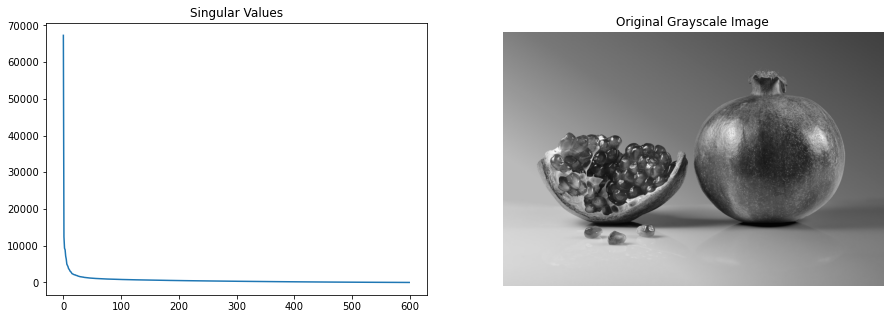

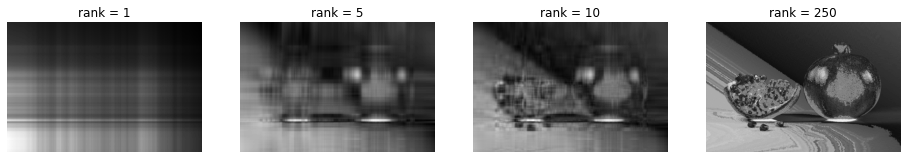

In [2]:
## Initialize Matplotlib plots for displaying the images
fig2, ax2 = plt.subplots(1,2,figsize=(15,5))
fig, ax = plt.subplots(1,4,figsize=(16,7))

# Init a list of output image ranks to iterate through
rank = [1,5,10,250]

# Loop through the list of ranks and create and graph an SVD compressed image
for i, rk in enumerate(rank):
    c_img = compress_image(img, rk)
    ax[i].imshow(c_img, cmap='gray')
    ax[i].set_axis_off()
    title = 'rank = ' + str(rk)
    ax[i].set_title(title)
    

# Plot the Singular Values of the original image
U, S, Vt = np.linalg.svd(img, full_matrices=True)
ax2[0].plot(S)
ax2[0].set_title('Singular Values')
ax2[1].imshow(img)
ax2[1].set_axis_off()
ax2[1].set_title('Original Grayscale Image')

Now the other image

(None, Text(0.5, 1.0, 'Original Grayscale Image'))

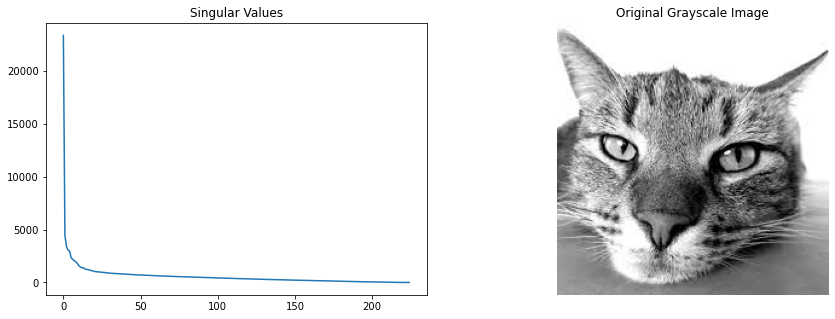

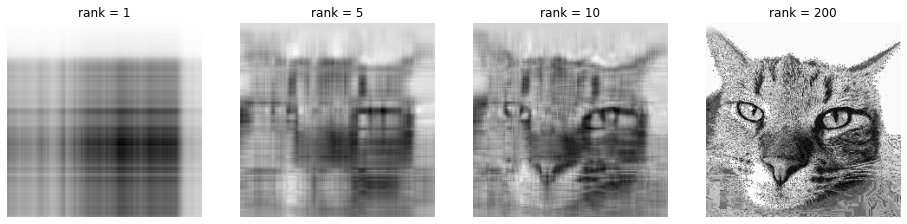

In [3]:
def invert_image(c_img):
    for i, row in enumerate(c_img):
        for j, pixel in enumerate(row):
            c_img[i][j] = 255 - c_img[i][j]   
    return c_img

img = Image.open(r'C:\Users\jonat\Documents\Code\cat.bmp')
fig2, ax2 = plt.subplots(1,2,figsize=(15,5))
fig, ax = plt.subplots(1,4,figsize=(16,7))

#   For some reason this image needed to be inverted again
rank = [1,5,10,200]
for i, rk in enumerate(rank):
    c_img = invert_image(compress_image(img, rk))
    ax[i].imshow(c_img, cmap='gray')
    ax[i].set_axis_off()
    title = 'rank = ' + str(rk)
    ax[i].set_title(title)
    

# Plot the Singular Values of the original image
U, S, Vt = np.linalg.svd(img, full_matrices=True)
ax2[0].plot(S), ax2[0].set_title('Singular Values'), ax2[1].imshow(img)
ax2[1].set_axis_off(), ax2[1].set_title('Original Grayscale Image')

## Compressing Colored Images
To compress colored images the only difference is that each channel needs to get the SVD treatement seperately and then stitched back together. 

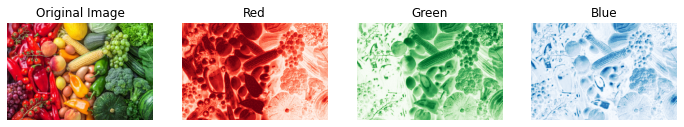

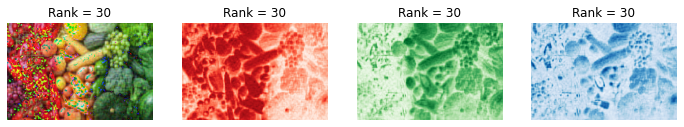

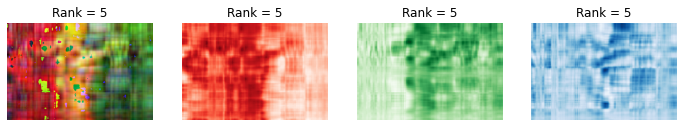

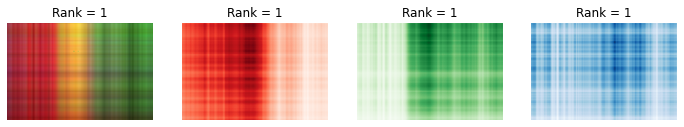

In [4]:
img = np.asarray(Image.open(r'C:\Users\jonat\Documents\Code\colorveggies.bmp'))
red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]


fig, ax = plt.subplots(1, 4, figsize=(12, 8))
ax[0].imshow(img), ax[0].set_title('Original Image'),
ax[1].imshow(red, cmap='Reds'), ax[1].set_title('Red'),
ax[2].imshow(green, cmap='Greens'), ax[2].set_title('Green'),
ax[3].imshow(blue, cmap='Blues'), ax[3].set_title('Blue')

for i in range(4):
    ax[i].set_axis_off()
img1 = np.zeros_like(img)
rank = [30,5,1]
for i, rk in enumerate(rank):
    red1, green1, blue1 = (compress_image(red, rk)), (compress_image(green, rk)), (compress_image(blue, rk))
    fig1, ax1 = plt.subplots(1, 4, figsize=(12, 8))
    for i in range(4):
        ax1[i].set_axis_off()
    img1[:,:,0], img1[:,:,1], img1[:,:,2] = red1, green1, blue1
    title = 'Rank = ' + str(rk)
    ax1[0].imshow(img1), ax1[0].set_title(title), ax1[1].imshow(red1, cmap='Reds'), ax1[1].set_title(title),
    ax1[2].imshow(green1, cmap='Greens'), ax1[2].set_title(title), ax1[3].imshow(blue1, cmap='Blues'), ax1[3].set_title(title)
    

# Video Compression

Now we move on and try to compress videos. This next function takes a video file and breaks it up into jpeg files.

In [113]:
import cv2
import numpy as np
import os
import sys
import argparse

def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    while success:
        success,image = vidcap.read()
        cv2.imwrite( pathOut + "\\frame%d.jpg" % count, image)     # save frame as JPEG file
        count = count + 1
    print(count, ' Pictures Created From The Video')
    
# Uncomment to run
#extractImages('C:\\Users\\jonat\\Documents\\Code\\VideoCompression\\cat.mp4', 'C:\\Users\\jonat\\Documents\\Code\\VideoCompression\\Cat_Images\\')


## Threaded Compression

Now that we have a folder of JPEGs, we can iterate through them, compress them using the SVD method, and save them to another folder. 

Doing successive operations on images takes a lot of time and I do not have a GPU to speed it up, I have done the minimal level of multithreading to make it faster. 

In [103]:
from concurrent import futures
from itertools import repeat

# Insert path to images and output path
image_folder = 'C:\\Users\\jonat\\Documents\\Code\\VideoCompression\\Cat_Images\\'
new_image_folder = 'C:\\Users\\jonat\\Documents\\Code\\VideoCompression\\Cat_Images_Compressed_Rank20\\'


# This function compresses a JPEG with a given rank
def threaded_compress_image(file, rk):
    
    img = np.asarray(Image.open(r'C:\Users\jonat\Documents\Code\VideoCompression\Cat_Images\\' + file))
    img1 = np.zeros_like(img)
    rgb_matrix = [img[:,:,0], img[:,:,1], img[:,:,2]]
    
    executer = futures.ThreadPoolExecutor(max_workers=3)
    results = executer.map(compress_image, rgb_matrix, repeat(rk))
    result_comp = [np.asarray(result) for i, result in enumerate(results)]
    
    img1[:,:,0], img1[:,:,1], img1[:,:,2] = result_comp[0], result_comp[1], result_comp[2]
    
    cv2.imwrite(new_image_folder + file, (img1))
    return None


images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]

def sortfunc(name):
    return int(name[5:-4])
images.sort(key=sortfunc)


rank = 20  # This is where you change the rank
executer = futures.ThreadPoolExecutor(max_workers=5
results = executer.map(threaded_compress_image, images, repeat(rank))
photos = [result for i, result in enumerate(results)]  # Iterate through all the images in the folder and comopress them.

print('Images Compressed')

Images Compressed


Here are some images from the compressed version of the MP4 File

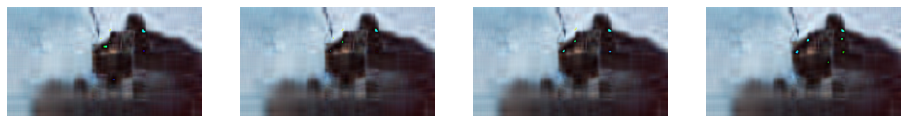

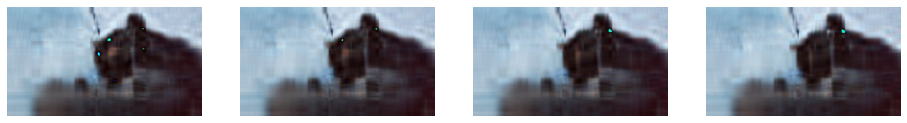

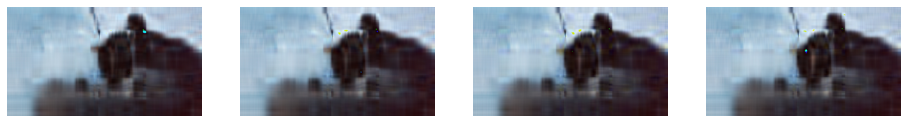

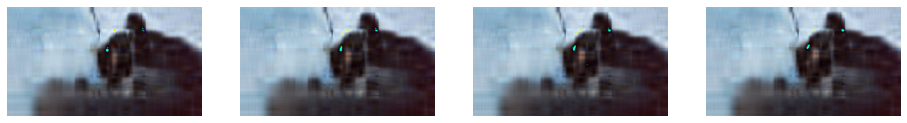

In [114]:
for row in range(4):
    fig, ax = plt.subplots(1, 4, figsize=(16, 8))
    for column in range(4):
        image = 'frame' + str(column + row * 4) + '.jpg'
        image = np.asarray(Image.open(r'C:\Users\jonat\Documents\Code\VideoCompression\Cat_Images_Compressed_Rank10\\' + image))
        ax[column].imshow(image), ax[column].set_axis_off()

## Stitching The Movie Back Together

This is just a function partially ripped from stack exchange for stiching images back into a MP4 file, I run this block with different input and output paths to create each compressed video.

In [104]:
video_file = 'C:\\Users\\jonat\\Documents\\Code\\VideoCompression\\Cat_Stitched_RankFull.mp4'
image_folder = 'C:\\Users\\jonat\\Documents\\Code\\VideoCompression\\Cat_Images_Compressed_Rank20\\'
image_size = (1920, 1080)
fps = 29

def sortfunc(name):
    #print(name[5:-4])
    return int(name[5:-4])
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort(key=sortfunc)

out = cv2.VideoWriter(video_file, cv2.VideoWriter_fourcc(*'MP4V'), fps, image_size)

img_array = []
for filename in images:
    img = cv2.imread(os.path.join(image_folder, filename))
    img_array.append(img)
    out.write(img)

out.release()
print('Video Stitched')

Video Stitched
